In [44]:
import sys
import numpy as np
import scipy
import subprocess
from natsort import natsorted
import itertools
import pandas as pd
import torch
sys.path.append("../utls")
sys.path.append("../utls")
sys.path.append("../.")
sys.path.append("../models")
from collections import Counter
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import torchvision
import torchvision.transforms
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from utls.preprocessing import *
from utls.postprocessing import get_dataset, generate_hist_df
from InterfaceDeclaration import LPBFInterface
from models.MLUtls import fade_in_out, standardize_tensor, getKFoldCrossValidationIndexes, train_log, transform_ft, dataset_by_cross_validation, labels_by_classes, get_current_fold_and_hist, LPBFDataset
from models.MLModels import SVMModel, CNN_Base_1D_Model, ResNet15_1D_Model

alphabet = list(string.ascii_lowercase)

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

sampling_rate_daq: int = int(1.25 * 1e6)
sampling_rate_lmq: int = int(0.1 * 1e6)
tdms_daq_list = natsorted(
    [i for i in os.listdir(daq_dir) if i.split(".")[-1] == "tdms"]
)
bin_lmq_list = natsorted([i for i in os.listdir(lmq_dir) if i.split(".")[-1] == "bin"])
lmq_channel_name = [
    "Vector ID",
    "meltpooldiode",
    "X Coordinate",
    "Y Coordinate",
    "Laser power",
    "Spare",
    "Laser diode",
    "Varioscan(focal length)",
]
process_regime = [
    [0,    59, "Base"  ], 
    [60,  129, "KH"    ], 
    [130, 199, "Normal"], 
    [200, 269, "RLoF"  ], 
    [269, 339, "LoF"   ] 
]

In [65]:
with open(os.path.join("../",'outputs',"intermediate",f"sc_power.pkl"), 'rb') as handle:
    sc_power = pickle.load(handle)

with open(os.path.join("../",'outputs',"intermediate",f"le_speed.pkl"), 'rb') as handle:
    le_speed = pickle.load(handle)

with open(os.path.join("../",'outputs',"intermediate",f"le_region.pkl"), 'rb') as handle:
    le_region = pickle.load(handle)

with open(os.path.join("../",'outputs',"intermediate",f"le_direction.pkl"), 'rb') as handle:
    le_direction = pickle.load(handle)

ae_cf_direction  = np.load("../outputs/intermediate/ae_cf_direction.npy")
mic_cf_direction = np.load("../outputs/intermediate/mic_cf_direction.npy")
ae_cf_position  = np.load("../outputs/intermediate/ae_cf_position.npy")
mic_cf_position = np.load("../outputs/intermediate/mic_cf_position.npy")

In [54]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.3}\%".format(value*100) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.tick_params(
        axis='both', # changes apply to both axis
        which='both', # both major and minor ticks are affected
        top=False, 
        bottom=False, 
        left=False,
        right=False,
        )

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

def merge_confusion_matrix(merge_mapping, cm):
    # Number of unique classes after merging
    num_new_classes = len(set(merge_mapping.values()))

    # Initialize the new confusion matrix
    new_cm = np.zeros((num_new_classes, num_new_classes), dtype=int)

    # Populate the new confusion matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            new_cm[merge_mapping[i], merge_mapping[j]] += cm[i, j]
    return new_cm

In [52]:
def pop_array(y,pop_index,axis=0):
    if axis==0:
        y = np.concatenate([y[:pop_index],y[pop_index+1:]])
    if axis==1:
        y = np.concatenate([y[:,:pop_index],y[:,pop_index+1:]],axis=1)
    return y

In [48]:
categories = le_direction.inverse_transform([0,1,3,4])
categories = ["-150°","-60°","120°","30°"]

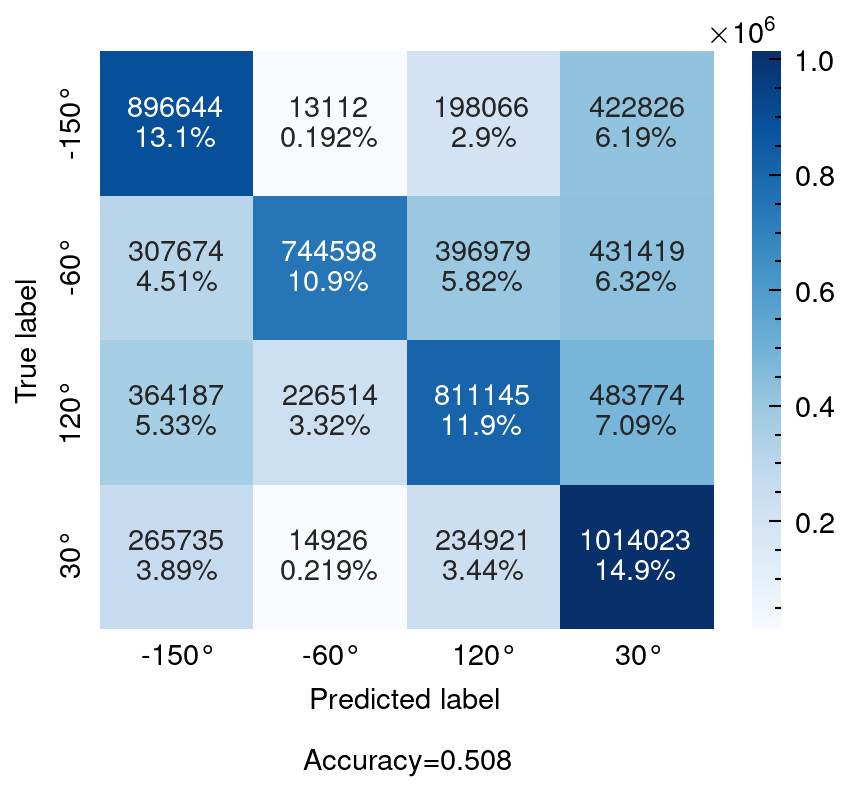

In [49]:
make_confusion_matrix(pop_array(pop_array(ae_cf_direction.sum(axis=0),2),2,axis=1),
# make_confusion_matrix(ae_cf_direction.sum(axis=0),
                      categories=categories)

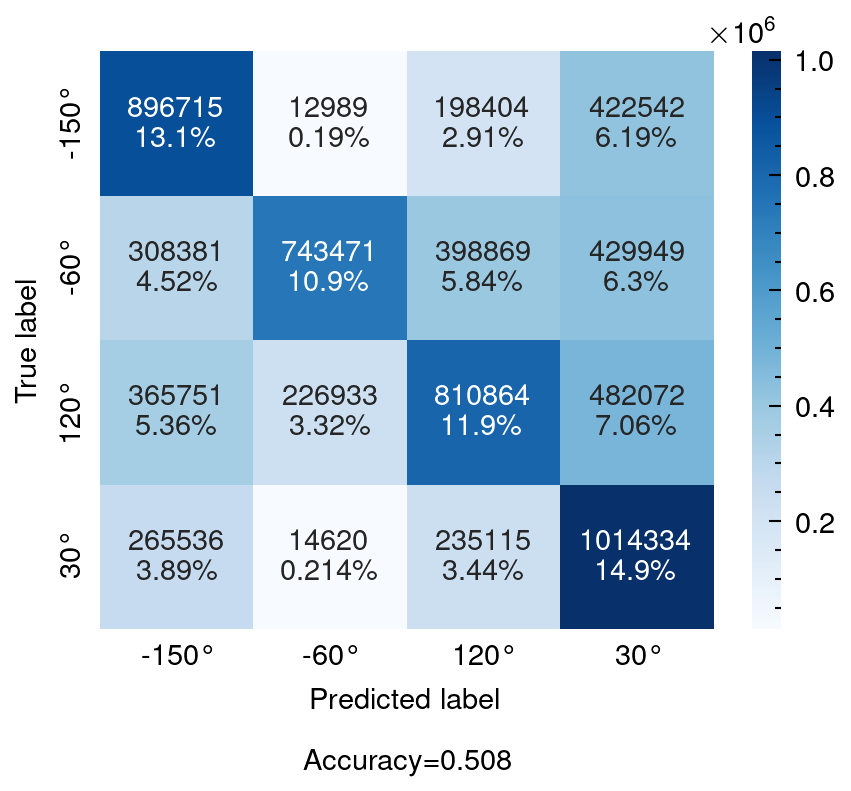

In [50]:
make_confusion_matrix(pop_array(pop_array(mic_cf_direction.sum(axis=0),2),2,axis=1),
                      categories=categories)

In [66]:
merge_mapping = {
    0: 0,  # Class 0 remains as is
    1: 1,  # Class 1 merges into new class 1
    2: 1,  # Class 2 merges into new class 1
    3: 0   # Class 3 becomes new class 2
}
categories=["Horizontal", "Vertical"]
m_ae_cf_direction = merge_confusion_matrix(merge_mapping, pop_array(pop_array(ae_cf_direction.sum(axis=0),2),2,axis=1))
m_mic_cf_direction = merge_confusion_matrix(merge_mapping, pop_array(pop_array(mic_cf_direction.sum(axis=0),2),2,axis=1))
m_ae_cf_position = merge_confusion_matrix(merge_mapping, pop_array(pop_array(ae_cf_position.sum(axis=0),2),2,axis=1))
m_mic_cf_position = merge_confusion_matrix(merge_mapping, pop_array(pop_array(mic_cf_position.sum(axis=0),2),2,axis=1))

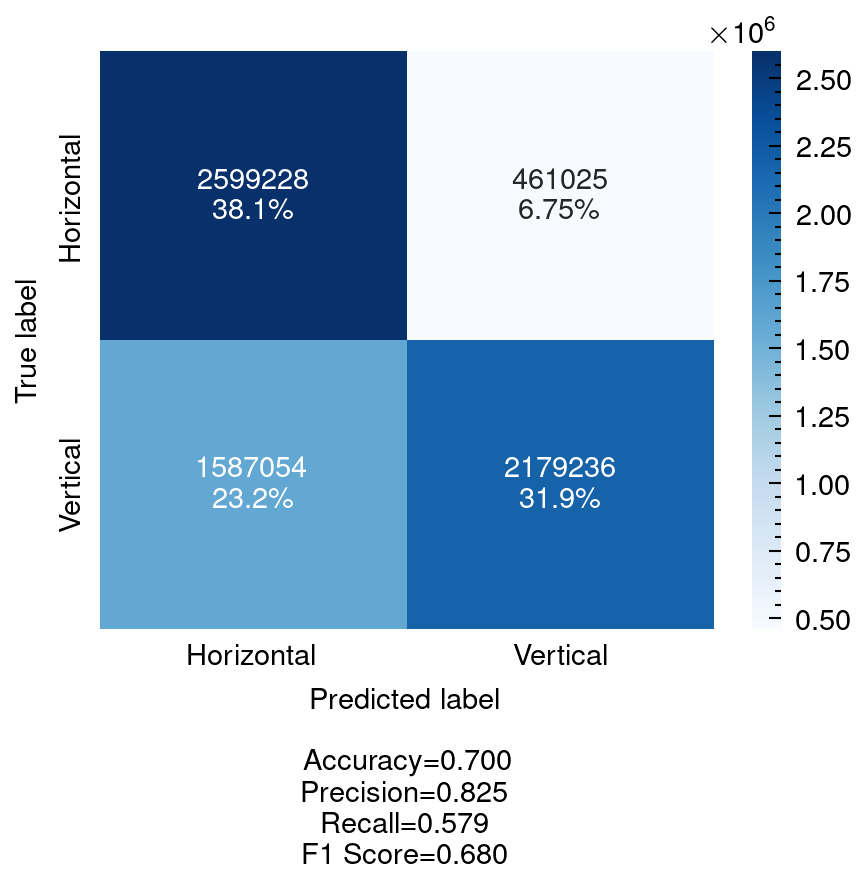

In [67]:
m_ae_cf_direction = merge_confusion_matrix(merge_mapping, pop_array(pop_array(ae_cf_direction.sum(axis=0),2),2,axis=1))
make_confusion_matrix(m_ae_cf_direction,categories=categories)
plt.savefig(f"../outputs/raw_binary_ae_dirction.png",dpi=600)

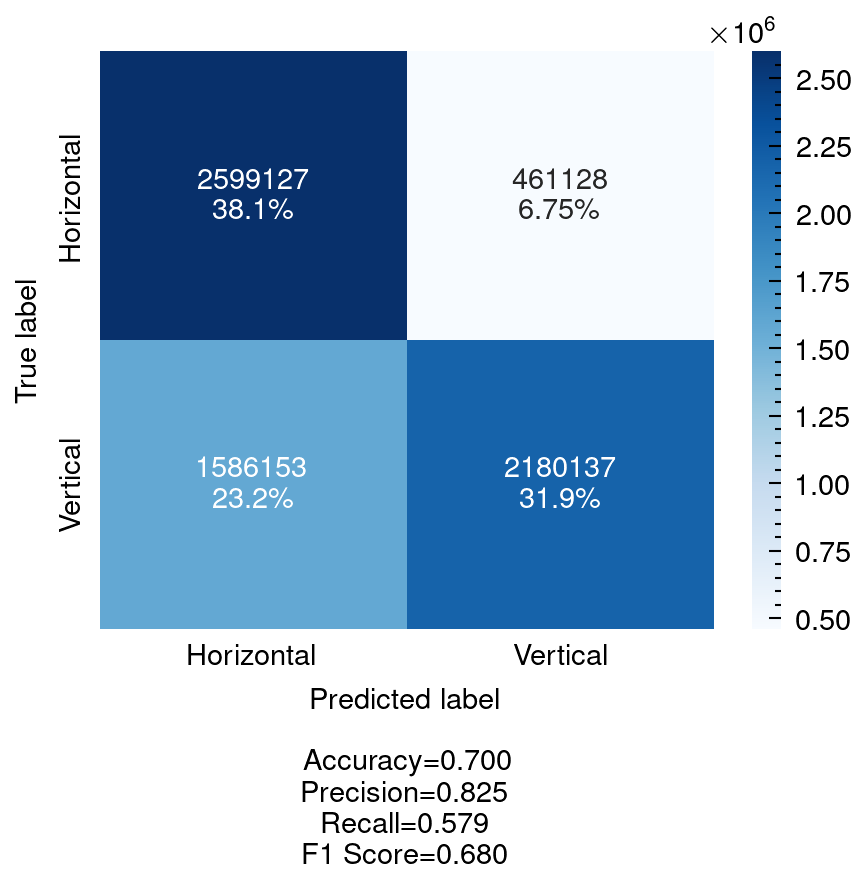

In [69]:
m_mic_cf_direction = merge_confusion_matrix(merge_mapping, pop_array(pop_array(mic_cf_direction.sum(axis=0),2),2,axis=1))
make_confusion_matrix(m_mic_cf_direction,categories=categories)
plt.savefig(f"../outputs/raw_binary_mic_dirction.png",dpi=600)

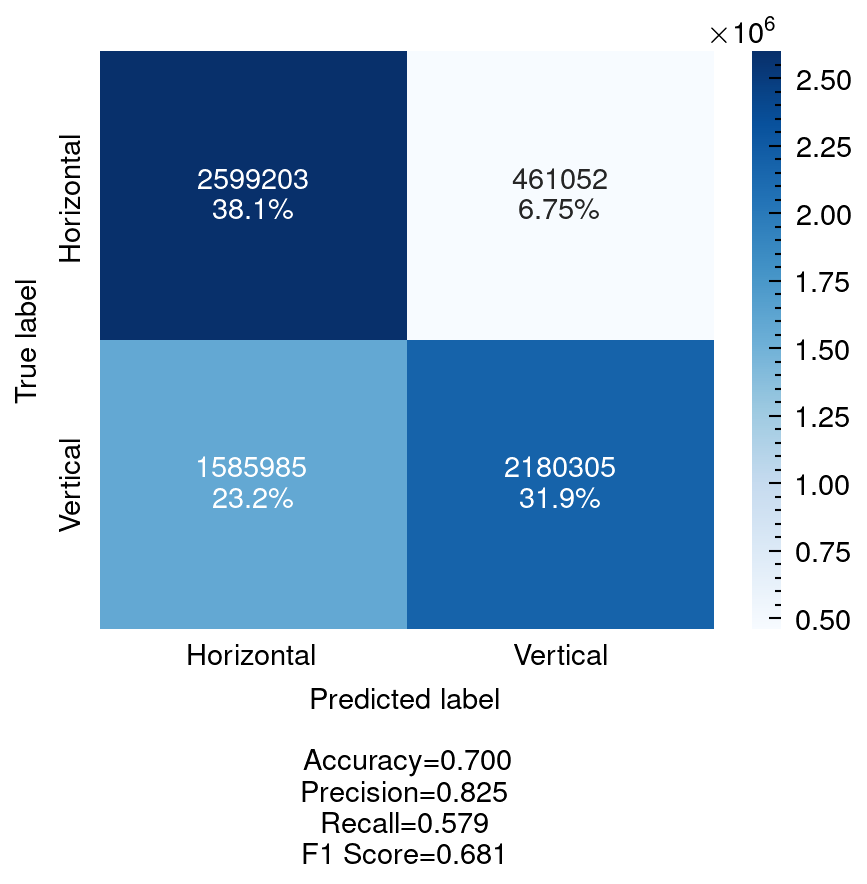

In [74]:
m_ae_cf_position = merge_confusion_matrix(merge_mapping, pop_array(pop_array(ae_cf_position.sum(axis=0),2),2,axis=1))
make_confusion_matrix(m_ae_cf_position,categories=categories)
plt.savefig(f"../outputs/raw_binary_ae_position.png",dpi=600)

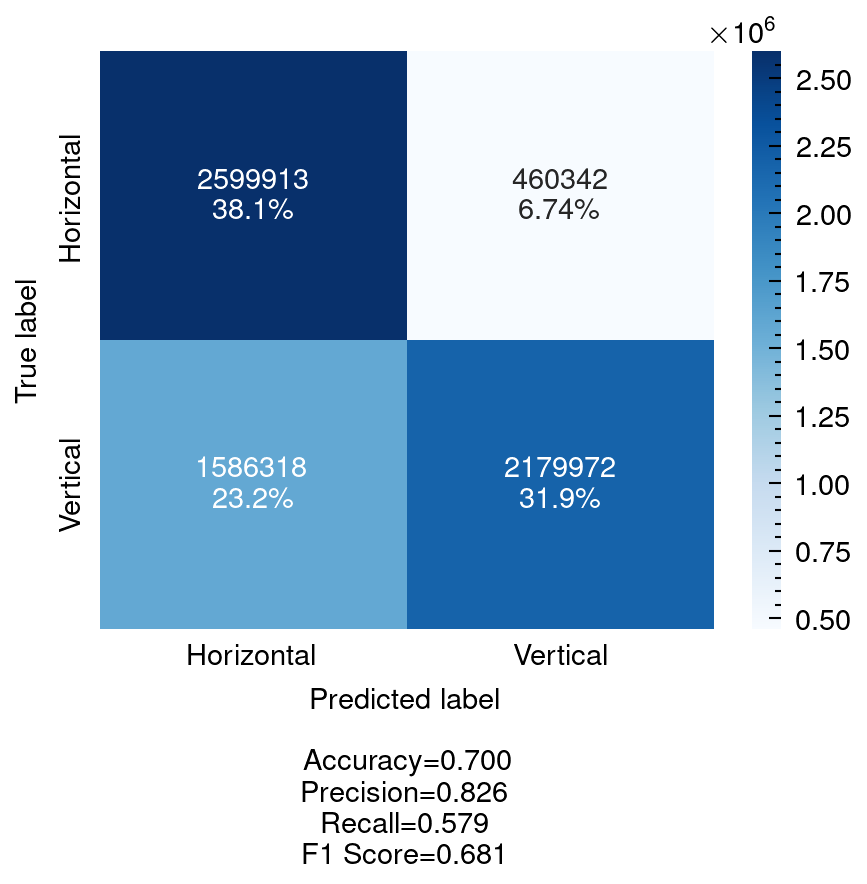

In [72]:
m_mic_cf_position = merge_confusion_matrix(merge_mapping, pop_array(pop_array(mic_cf_position.sum(axis=0),2),2,axis=1))
make_confusion_matrix(m_mic_cf_position,categories=categories)
plt.savefig(f"../outputs/raw_binary_mic_position.png",dpi=600)